In [1]:
#Data website: 
# https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.


# First, we read in the file and import packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture as GMM

import warnings
warnings.filterwarnings("ignore")

/Users/rabeya/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load the HCC data
DBdata = pd.read_csv('diabetes_data_upload.csv')

In [3]:
DBdata.shape

(520, 17)

In [4]:
DBdata.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [5]:
DBdata.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [8]:
DBdata['class'].value_counts()

Positive    320
Negative    200
Name: class, dtype: int64

In [10]:
# first, we should convert all the "Yes" into 1 and "No" into 0.
# the way to do this would be to map a dictionary into python
binary_dict = {'Yes':1, 'No':0}
gender_dict = {'Male':0, 'Female':1}

In [11]:
DBdata_copy = DBdata.copy()
for name in DBdata.columns[2:-1]:
    # every column is a pandas Series
    x = DBdata[name]
    DBdata_copy[name] = x.map(binary_dict)

DBdata_copy.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,Positive
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,Positive
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,Positive
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,Positive
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,Positive


In [12]:
DBdata_copy['Gender'] = DBdata['Gender'].map(gender_dict)
DBdata_copy.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,Positive
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,Positive
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,Positive
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,Positive
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,Positive


In [13]:
X = DBdata_copy.iloc[:, :-1]
y = np.asarray(DBdata_copy.iloc[:, -1])

# lets pick the K features with the highest mutual information relative to label
# one challenge would be to reduce the amount of features while still keeping
# the similar predictive quality from Density estimation

# let's have K = 4 features  
K = 4
selector = SelectKBest(mutual_info_classif, K)
X_reduced = selector.fit_transform(X,y) 
features_selected = selector.get_support()

In [15]:
# these are the K top features by the mutual-information score
feature_names_selected = np.where(features_selected==True)[0].tolist()
all_features = np.asarray(X.columns)
Kbest_features = all_features[feature_names_selected]

In [16]:
print(Kbest_features)

['Age' 'Polyuria' 'Polydipsia' 'partial paresis']


In [17]:
X_reduced.shape, y.shape

((520, 4), (520,))

In [ ]:
np.random.seed(60)

In [18]:
# first we need to split X_reduced the training and testing datsets
# we're going to do a 60%-40% split on the training data and test data.
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, train_size=0.7)

In [24]:
np.unique(y_train, return_counts=True)

(array(['Negative', 'Positive'], dtype=object), array([143, 221]))

In [15]:
# first we need to split X_train based on positive and negative class
X_pos = X_train[np.where(y_train=='Positive'),:][0]
X_neg = X_train[np.where(y_train=='Negative'),:][0]

In [16]:
X_pos.shape, X_neg.shape

((221, 5), (143, 5))

Let's do a quick t-SNE plot to visualize the clusters in our data distribution!
Basically, all a t-SNE plot does is project (nonlinearly) the data set from 17 dimensions
down to just 2 dimensions, so we can visualize (with different colors and labels) how
the dataset looks like (its probability distribution)!

In [17]:
# t-SNE plot!
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 520 samples in 0.001s...
[t-SNE] Computed neighbors for 520 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 520 / 520
[t-SNE] Mean sigma: 1.789309
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.407642
[t-SNE] KL divergence after 300 iterations: 0.264732


In [18]:
tsne_results.shape

(520, 2)

In [19]:
# let's start plotting the t_SNE!
import matplotlib.patheffects as PathEffects
%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
RS = 123

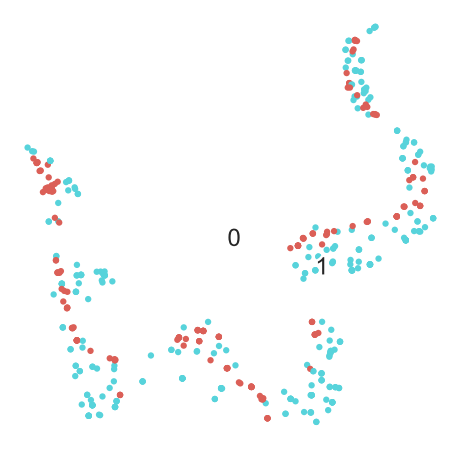

In [20]:
# choose a color palette with seaborn.
colors = pd.Series(y).map({'Positive':1, 'Negative':0})
x = tsne_results

num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):
    # Position of each label at median of data points.
    xtext, ytext = np.median(x[colors == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)

Great! Now, let's take the shortened dataset, 
and calculate the ditribution of X_reduced according to the labels
let's estimate the density (the likelihood) model!
let's first create M Gaussian Mixture models. We'll set M = 50.

In [21]:
M = 50
n_components = np.arange(1, M, 1)
pos_models = [GMM(n, covariance_type='tied', tol=1e-4) for n in n_components]
neg_models = [GMM(n, covariance_type='tied', tol=1e-4) for n in n_components]

In [22]:
# now tht the models were created, time to fit!
# we'll be using the Akaike Information Criteria (AIC) to judge whether
# the model may be overfitting or underfitting, find a balance

# nevermind i'm wrong AIC gives a relative measure of models, we still have to 
# the extra code lines here add a cute small progress bar :3 
import time
from tqdm import tqdm_notebook as tqdm

pos_aics = []
neg_aics = []

print("Fitting {} density models...".format(M))
for model in tqdm(pos_models):
    aic = model.fit(X_pos).aic(X_pos)
    pos_aics.append(aic)
    time.sleep(0.2)
    

print("Fitting {} density models...".format(M))
for model in tqdm(neg_models):
    aic = model.fit(X_neg).aic(X_neg)
    neg_aics.append(aic)
    time.sleep(0.2)

Fitting 50 density models...



Fitting 50 density models...


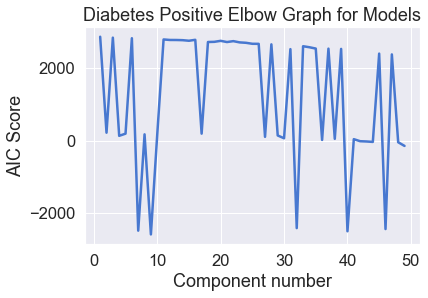

In [23]:
# plot the positive aic-curve
plt.xlabel('Component number')
plt.ylabel('AIC Score')
plt.title('Diabetes Positive Elbow Graph for Models')
plt.plot(n_components, pos_aics)
plt.show()

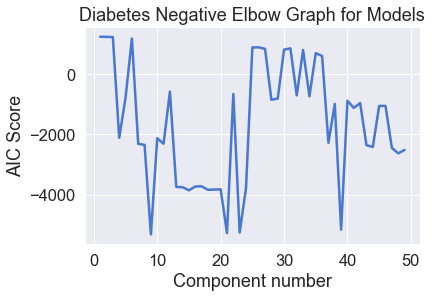

In [24]:
# plot the negative aic-curve
plt.xlabel('Component number')
plt.ylabel('AIC Score')
plt.title('Diabetes Negative Elbow Graph for Models')
plt.plot(n_components, neg_aics)
plt.show()

In [25]:
# from this, we should prolly choose  the elbow-point components for the 
# Positive_class density models
# and about the elbow-point components for the Negative_class models

gmm_pos = GMM(3, covariance_type='tied',tol=1e-4)
gmm_pos.fit(X_pos)
gmm_neg = GMM(3, covariance_type='tied',tol=1e-4)
gmm_neg.fit(X_neg)


GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.0001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

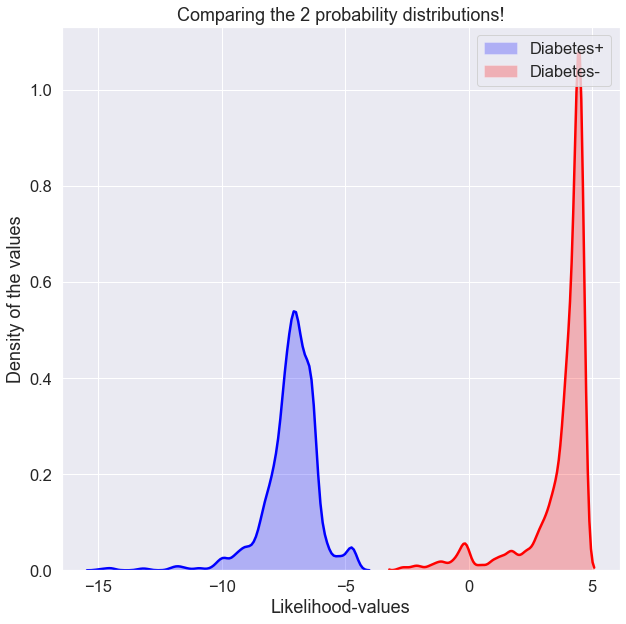

In [78]:
# let's graph the Gaussian Mixtures  together!
# first we will sample N new points from the fited distribution, and then graph the
# model's LIKELIHOOD values of the samples (x-axis), versus its density (as a frequency histogram)
N = 1000
# Diabetes+ samples
sample_pos, _ = gmm_pos.sample(N)
sample_pos = sample_pos.astype(int)
sample_likelihoods_pos = gmm_pos.score_samples(sample_pos)

# then Diabetes– samples
sample_neg, _ = gmm_neg.sample(N)
sample_neg = sample_neg.astype(int)
sample_likelihoods_neg = gmm_neg.score_samples(sample_neg)




# -------------- plotting time----------------
plt.figure(figsize=(10,10))
diabetes_pos = sns.kdeplot(sample_likelihoods_pos, shade=True, color='b')
diabetes_neg = sns.kdeplot(sample_likelihoods_neg, shade=True, color='r')
plt.title('Comparing the 2 probability distributions!')
plt.ylabel('Density of the values')
plt.xlabel('Likelihood-values')
plt.legend(['Diabetes+', 'Diabetes-'], loc='upper right')
plt.show()


Now in order to apply Gaussian Mixture modeling as a predictive tool, ket's go back to the Bayesian inference hypothesis equation above. Because we balanced the class labels in our dataset, the quotient $\frac{P(H_1)}{P(H_2)}$ is 1 because the ratio of life-labels to death-labels is the same. So we only have to worry about the likelihood ratio. 

Dividing numbers in Python can give weird errors, so instead, we'll work with the *logarithm* of the likelihood ratio, written as:

$$log(\frac{P(Data|H_1)}{P(Data|H_2)})$$

which can be written as:

$$LogLikelihoodOdds = log(P(Data|H_1) - log(P(Data|H_2))$$

The numerator we'll call *life_log_prob* and the denominator as *death_log_prob*.

Our key calculation is this: in the quotient of likelihoods, if the quotient is > 1, then the likelihood of the test data point under hypothesis 1 (class label=1) is higher than class label 0, so we classify it as "survival". Otherwise, it's classified as "death". When we take the logarithm of the likelihood ratio, what this classification rule translates to is that we classify the new data point as "survival" if the difference, $delta$ > 0, and "death" if $delta$ < 0.

In [79]:
log_likelihood_odds = np.subtract(gmm_pos.score_samples(X_test), gmm_neg.score_samples(X_test))

# in this case the prior proportions of labels in the training set is NOT 50:50, 
# so we need to incorporate the log-difference in the prior proportions first
num_pos = Counter(y_train)['Positive']
num_neg = Counter(y_train)['Negative']
log_prior_odds = np.repeat(np.log(num_pos/num_neg), len(log_likelihood_odds))

# calculate the log-posterior for each data point using log-version of Bayes formula
# this is the inference part
log_posterior_odds = np.add(log_likelihood_odds, log_prior_odds)

# finally put the results into a prediction list :)
gmm_predictions = [1 if x>0 else 0 for x in log_posterior_odds]
gmm_predictions = np.asarray(gmm_predictions)

In [80]:
results_dict = {'Positive':1, 'Negative': 0}
y_test_encode = np.vectorize(results_dict.get)(y_test)

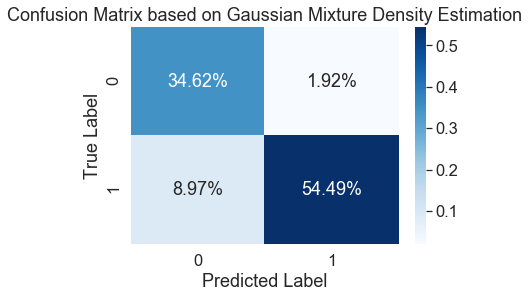

In [81]:
cf_matrix = confusion_matrix(y_true=np.asarray(y_test_encode), y_pred=gmm_predictions)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix based on Gaussian Mixture Density Estimation')
plt.show()

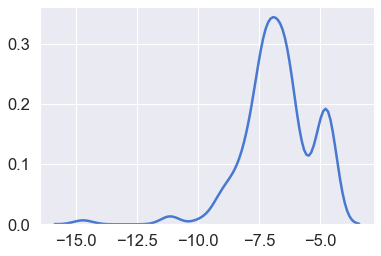

In [82]:
pos_test = gmm_pos.score_samples(X_test)

sns.kdeplot(pos_test)
plt.show()

In [86]:
#lets' fnd the middle 95% IQR range
p1 = np.percentile(pos_test, 2.0)
p2 = np.percentile(pos_test, 95.0)
gmm_preds_pos_only = np.asarray([1 if ((i >= p1) and (i <= p2)) else 0 for i in pos_test])
print(p1, p2)

-9.80136868497293 -4.644386069488663


In [87]:
gmm_preds_pos_only

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

And here is the KDE-plot distribution of the general posterior!
Just like the Diabetes+ and Diabetes- likelihood plots above, let's do 
the same for the posterior. 

(This next part won't be super accurate, because we haven't actually computed
the Bayes posterior. That would involve doing inference over the actual model,
which you would do using MCMC-sampling or variational (minimizing a distance with
derivatves). We are simply taking n=1000 samples from gmm_pos and gmm_neg, adding
their difference with the prior-difference to get an APPROXIMATE shape of the 
posterior. But sometimes, that's all we can do to do a quick project. The actual 
inference should use PyMC3, a probabilistic-programming language.

In [30]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [88]:
grid_positive = GridSearchCV(KernelDensity(kernel = 'gaussian'),
                          {'bandwidth': np.linspace(0.1, 1.5, 100)}, cv = 8)

grid_negative = GridSearchCV(KernelDensity(kernel = 'gaussian'),
                          {'bandwidth': np.linspace(0.1, 1.5, 100)}, cv = 8)


grid_positive.fit(X_pos)
grid_negative.fit(X_neg)

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0,
                                     breadth_first=True, kernel='gaussian',
                                     leaf_size=40, metric='euclidean',
                                     metric_params=None, rtol=0),
             iid='warn', n_jobs=None,
             param_grid={'bandwidth': array([0.1       , 0.11414141, 0.12828283, 0.14242424, 0.15656566,
       0.17070707, 0.18484848, 0.1989899 , 0.213131...
       1.16060606, 1.17474747, 1.18888889, 1.2030303 , 1.21717172,
       1.23131313, 1.24545455, 1.25959596, 1.27373737, 1.28787879,
       1.3020202 , 1.31616162, 1.33030303, 1.34444444, 1.35858586,
       1.37272727, 1.38686869, 1.4010101 , 1.41515152, 1.42929293,
       1.44343434, 1.45757576, 1.47171717, 1.48585859, 1.5       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [89]:
pos_best_bw = grid_positive.best_params_
neg_best_bw = grid_negative.best_params_

In [90]:
pos_best_bw, neg_best_bw

({'bandwidth': 0.5949494949494949}, {'bandwidth': 0.22727272727272727})

In [34]:
KDE_positive = KernelDensity(bandwidth=pos_best_bw['bandwidth'])
KDE_negative = KernelDensity(bandwidth=neg_best_bw['bandwidth'])

KDE_positive.fit(X_pos)
KDE_negative.fit(X_neg)


KernelDensity(algorithm='auto', atol=0, bandwidth=0.2272727272727273,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

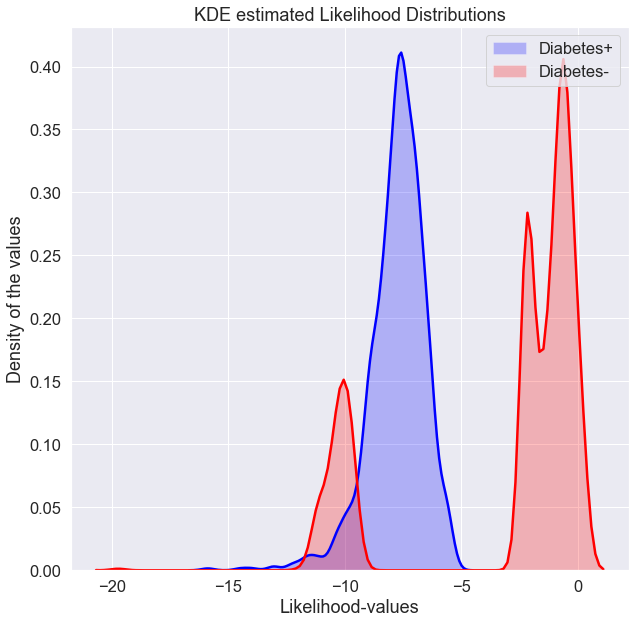

In [73]:
# let's graph the KDE distributions together!
# first we will sample N new points from the fited distribution, and then graph the
# model's LIKELIHOOD values of the samples (x-axis), versus its density (as a frequency histogram)
N = 1000
# Diabetes+ samples
sample_pos = KDE_positive.sample(N)
sample_pos = sample_pos.astype(int)
sample_likelihoods_pos = KDE_positive.score_samples(sample_pos)

# then Diabetes– samples
sample_neg = KDE_negative.sample(N)
sample_neg = sample_neg.astype(int)
sample_likelihoods_neg = KDE_negative.score_samples(sample_neg)





# plotting time!!! -------------------------------
plt.figure(figsize=(10,10))
diabetes_pos = sns.kdeplot(sample_likelihoods_pos, shade=True, color='b')
diabetes_neg = sns.kdeplot(sample_likelihoods_neg, shade=True, color='r')

plt.title('KDE estimated Likelihood Distributions')
plt.ylabel('Density of the values')
plt.xlabel('Likelihood-values')
plt.legend(['Diabetes+', 'Diabetes-'], loc='upper right')
plt.show()

In [36]:
# here we do bayesian inference using odds (and the kde-density estimate)

kde_log_likelihood_odds = np.subtract(KDE_positive.score_samples(X_test), KDE_negative.score_samples(X_test))

# in this case the prior proportions of labels in the training set is NOT 50:50, 
# so we need to incorporate the log-difference in the prior proportions first
num_pos = Counter(y_train)['Positive']
num_neg = Counter(y_train)['Negative']
log_prior_odds = np.repeat(np.log(num_pos/num_neg), len(kde_log_likelihood_odds))

# calculate the log-posterior for each data point using log-version of Bayes formula
# this is the inference part
log_posterior_odds = np.add(kde_log_likelihood_odds, log_prior_odds)

# finally put the results into a prediction list :)
kde_predictions = [1 if x>0 else 0 for x in log_posterior_odds]
kde_predictions = np.asarray(kde_predictions)

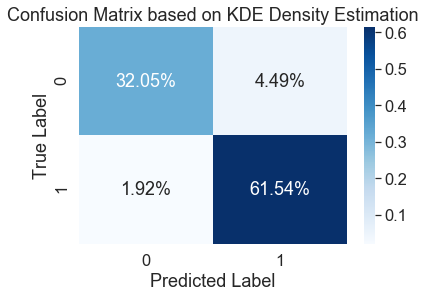

In [37]:
# and here we graph the confusion matrix

results_dict = {'Positive':1, 'Negative': 0}
y_test_encode = np.vectorize(results_dict.get)(y_test)

cf_matrix = confusion_matrix(y_true=np.asarray(y_test_encode), y_pred=kde_predictions)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix based on KDE Density Estimation')
plt.show()

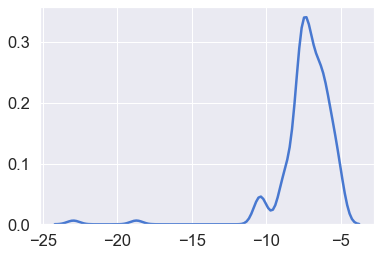

In [75]:
pos_test = KDE_positive.score_samples(X_test)

sns.kdeplot(pos_test)
plt.show()

In [76]:
#lets' fnd the middle 95% IQR range
p1 = np.percentile(pos_test, 10.0)
p2 = np.percentile(pos_test, 85.0)
kde_preds_pos_only = np.asarray([1 if ((i >= p1) and (i <= p2)) else 0 for i in pos_test])
kde_preds_pos_only

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1])